# Import Important Libraries

In [1]:
# Importing Libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, acf, pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
sys.path.append('../scripts')
from cleaner import CleanDataFrame
from plotter import Plotter
cleaner = CleanDataFrame()
plotter = Plotter()

# Read Data

In [2]:
train_data = pd.read_csv('../data/train.csv')
train_data = train_data[['Date','Sales']]
train_data = train_data.groupby('Date').agg({'Sales':'mean'})

# Scaleing the data

In [3]:
the_df = cleaner.scale_columns(train_data,['Sales'], range_tup=(-1,1))

In [4]:
scaled_data = cleaner.change_datatypes(the_df)

In [5]:
data = train_data

# Descriptive Statistics and Visualizations of the Data.

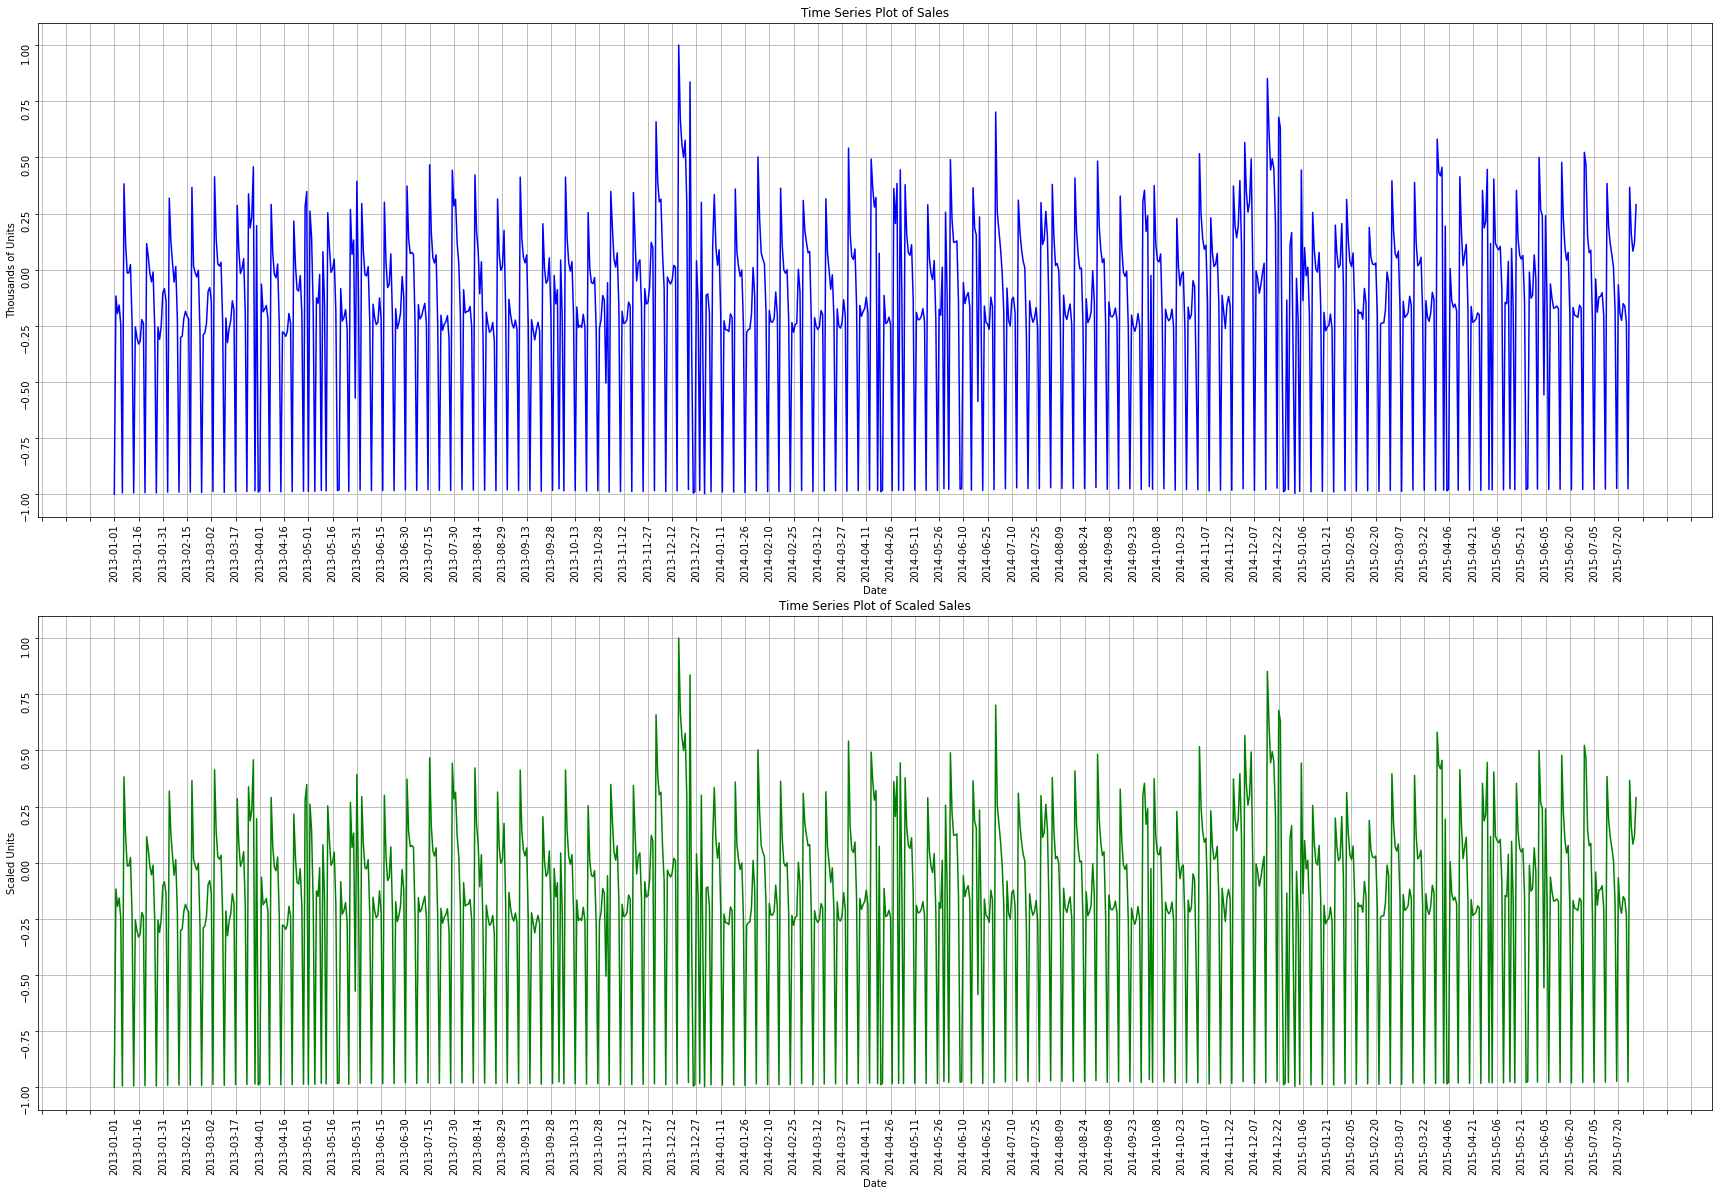

In [6]:
plotter.plot_time_series(data,scaled_data)

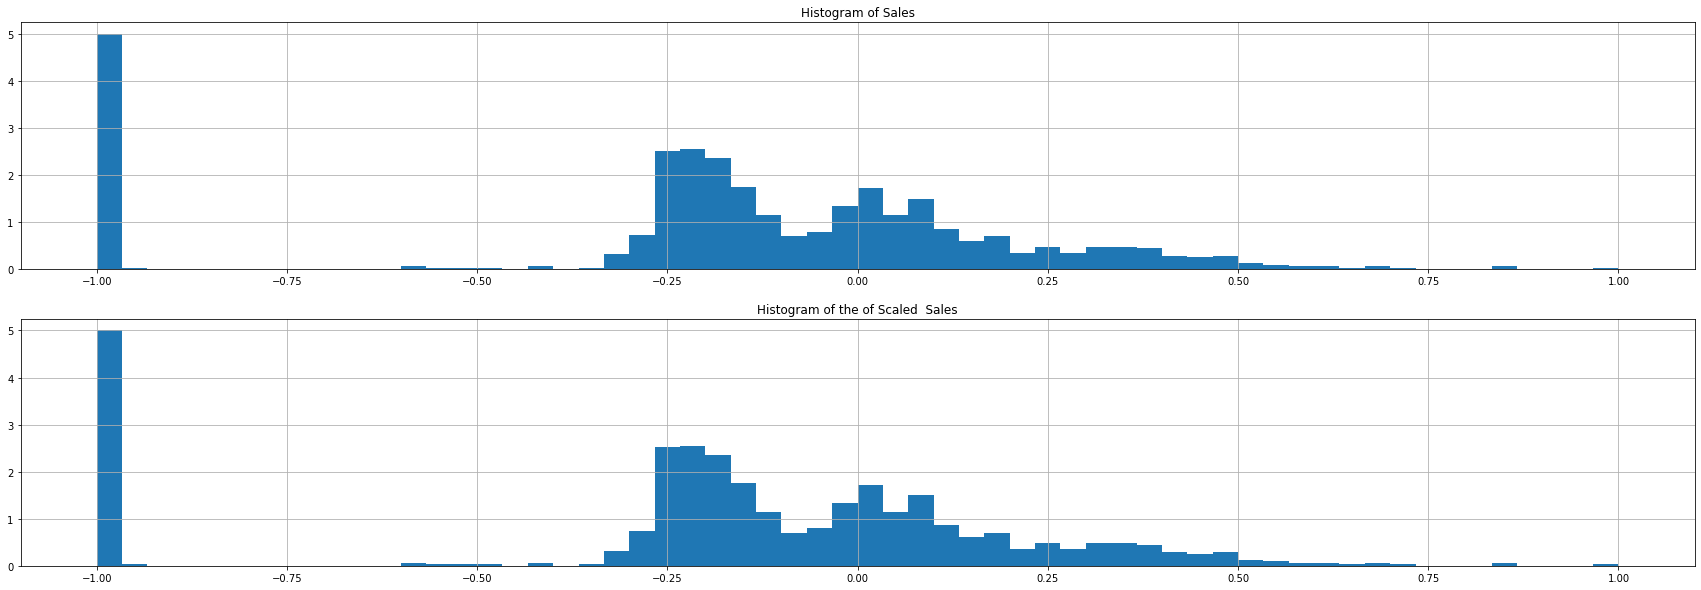

In [7]:
plotter.plot_histogram(data,scaled_data)

# Removing Stationarity

In [8]:
sales_difference = cleaner.get_difference(scaled_data.Sales.values)

# Autocorrelations and Partial Autocorrelations Plots.

In [9]:
acfSalesScaled = acf(scaled_data.Sales.values, fft=True, nlags=45)
acfSalesScaledNp = np.array(acfSalesScaled)

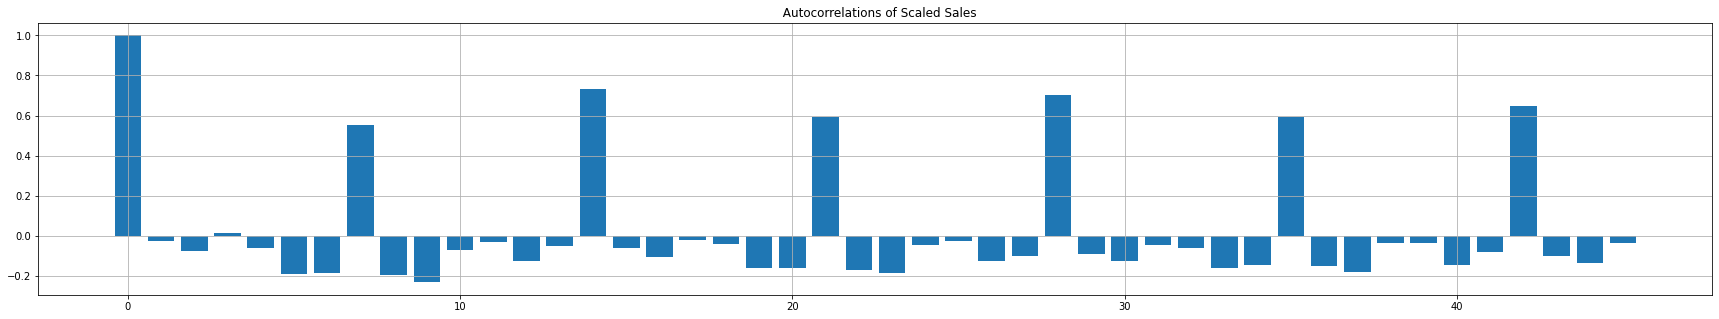

In [10]:
plotter.plot_correlations(acfSalesScaledNp, '')

In [11]:
pacfSalesScaled = pacf(scaled_data.Sales.values, nlags=45)
pacfSalesScaledNp = np.array(pacfSalesScaled)

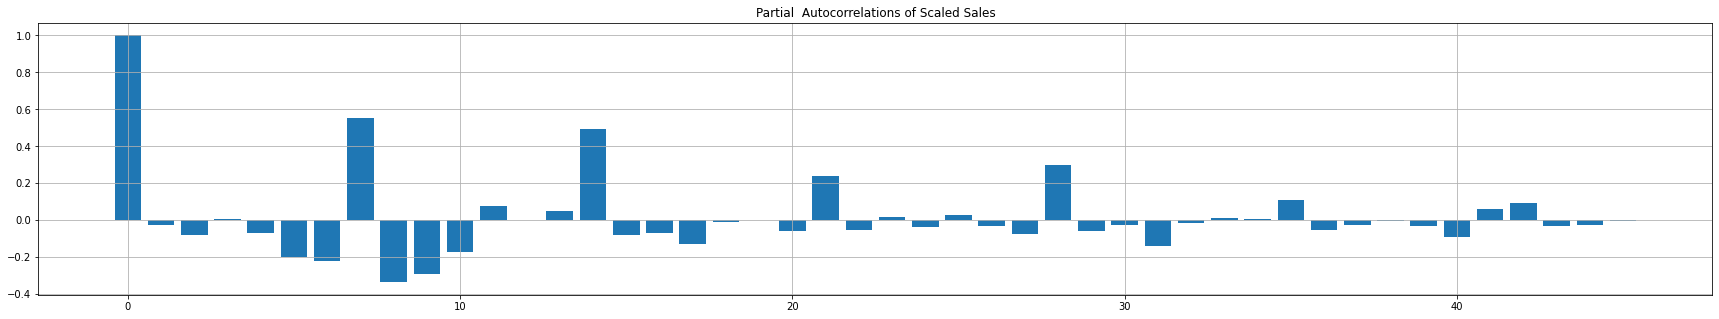

In [12]:
plotter.plot_correlations(pacfSalesScaledNp, "Partial")

# Separating into a Training and Validation Set Fomat to Use Feed into LSTM.

In [13]:
# Set window of past points for LSTM Model
SIZE = len(scaled_data.Sales)
WINDOW_SIZE = 45 # number of weeks to days
BATCH_SIZE = SIZE-WINDOW_SIZE*2
EPOCHS = 10

In [14]:
DateTrain = scaled_data.index.values[0:BATCH_SIZE]
DateValid = scaled_data.index.values[BATCH_SIZE:]
XTrain = scaled_data.Sales.values[0:BATCH_SIZE].astype('float32')
XValid = scaled_data.Sales.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (852, 1)
Shape of the validation set date series:  (90, 1)

Shape of the training set logarithm of sales series:  (852,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (90,)


In [15]:
tf.random.set_seed(0)
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([852, 1])

In [16]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [17]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [18]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)


# Define and Estimate the LSTM.

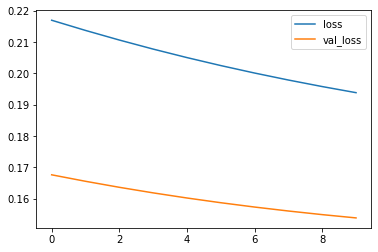

In [19]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')
history = model.fit(DatasetTrain, epochs=EPOCHS,
                    validation_data=DatasetVal, verbose=0)
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [20]:
# Set window of past points for LSTM model
window = 45

# # Split 80/20 into train/test data
last = int(len(scaled_data.Sales)/5.0)
Xtrain = scaled_data.Sales[:-last]
Xtest = scaled_data.Sales[-last-window:]

# # Store window number of points as a sequence
xin = []
next_X = []
for i in range(window, len(Xtrain)):
    try:
        xin.append(Xtrain[i-window:i])
        next_X.append(Xtrain[i])
    except Exception as e:
        print(f'i value : {i}')
        exit(0)

# Reshape data to format for LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1)

In [21]:
# Initialize LSTM model
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [22]:
# Fit LSTM model
history = m.fit(xin, next_X, epochs=700, batch_size=50, verbose=0)

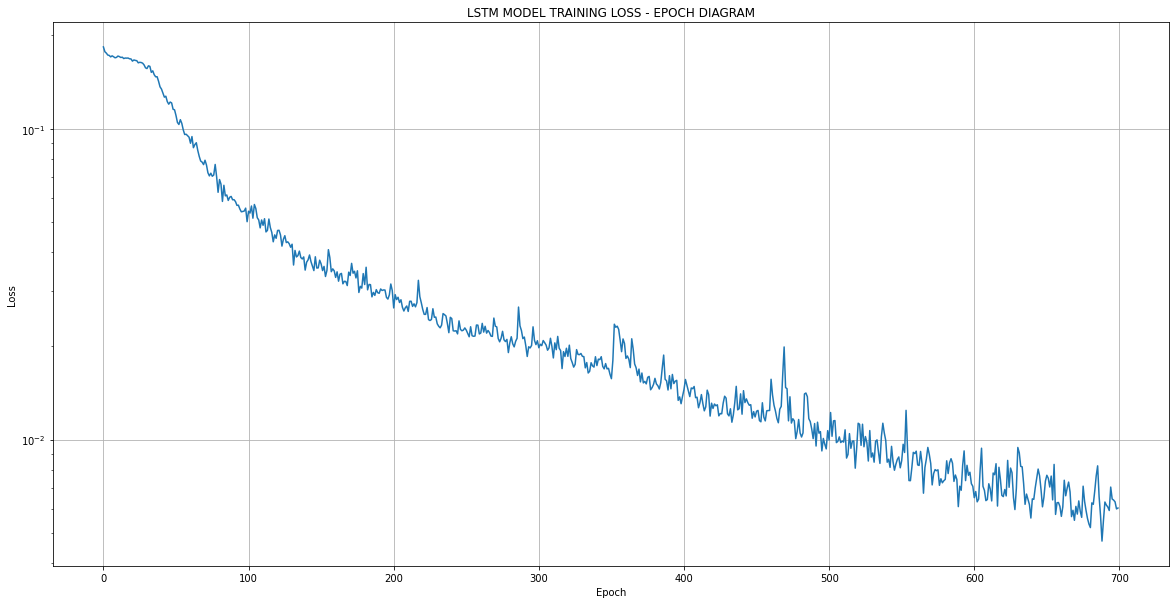

In [23]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.title('LSTM MODEL TRAINING LOSS - EPOCH DIAGRAM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])

In [24]:
# Last Loss Value
history.history['loss'][-1]

0.0060245078057050705

6/6 [==============================] - 1s 23ms/step


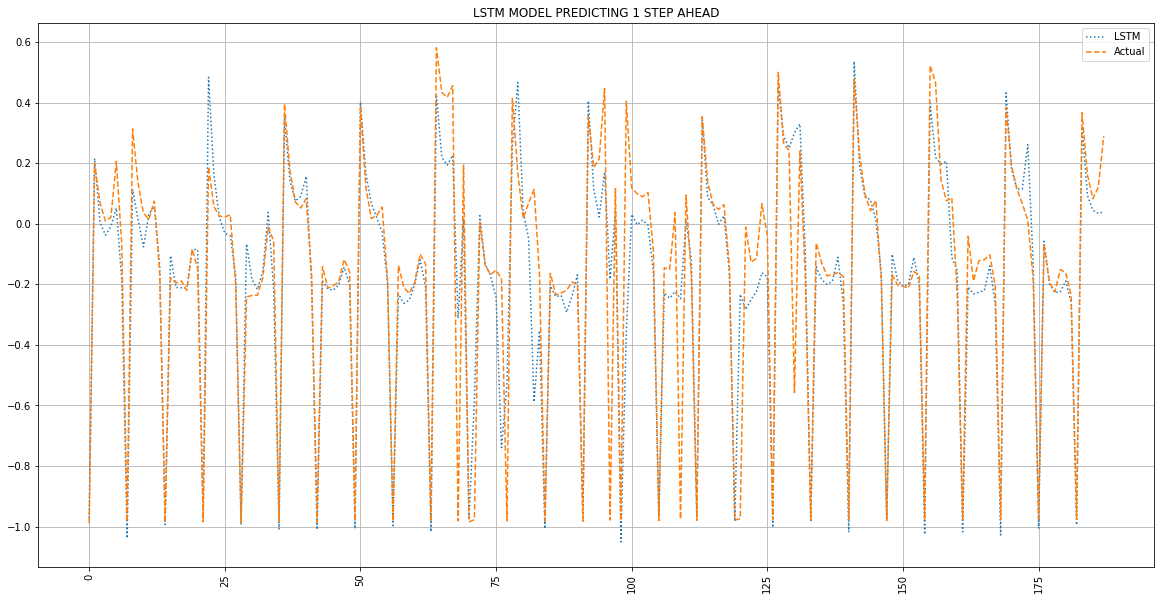

In [25]:
# Store "window" points as a sequence
xin = []
next_X1 = []
for i in range(window, len(Xtest)):
    xin.append(Xtest[i-window:i])
    next_X1.append(Xtest[i])

# Reshape data to format for LSTM
xin, next_X1 = np.array(xin), np.array(next_X1)
xin = xin.reshape((xin.shape[0], xin.shape[1], 1))

# Predict the next value (1 step ahead)
X_pred = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure(figsize=(20, 10))
plt.title('LSTM MODEL PREDICTING 1 STEP AHEAD')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred, ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()

1/1 [==============================] - 0s 31ms/step


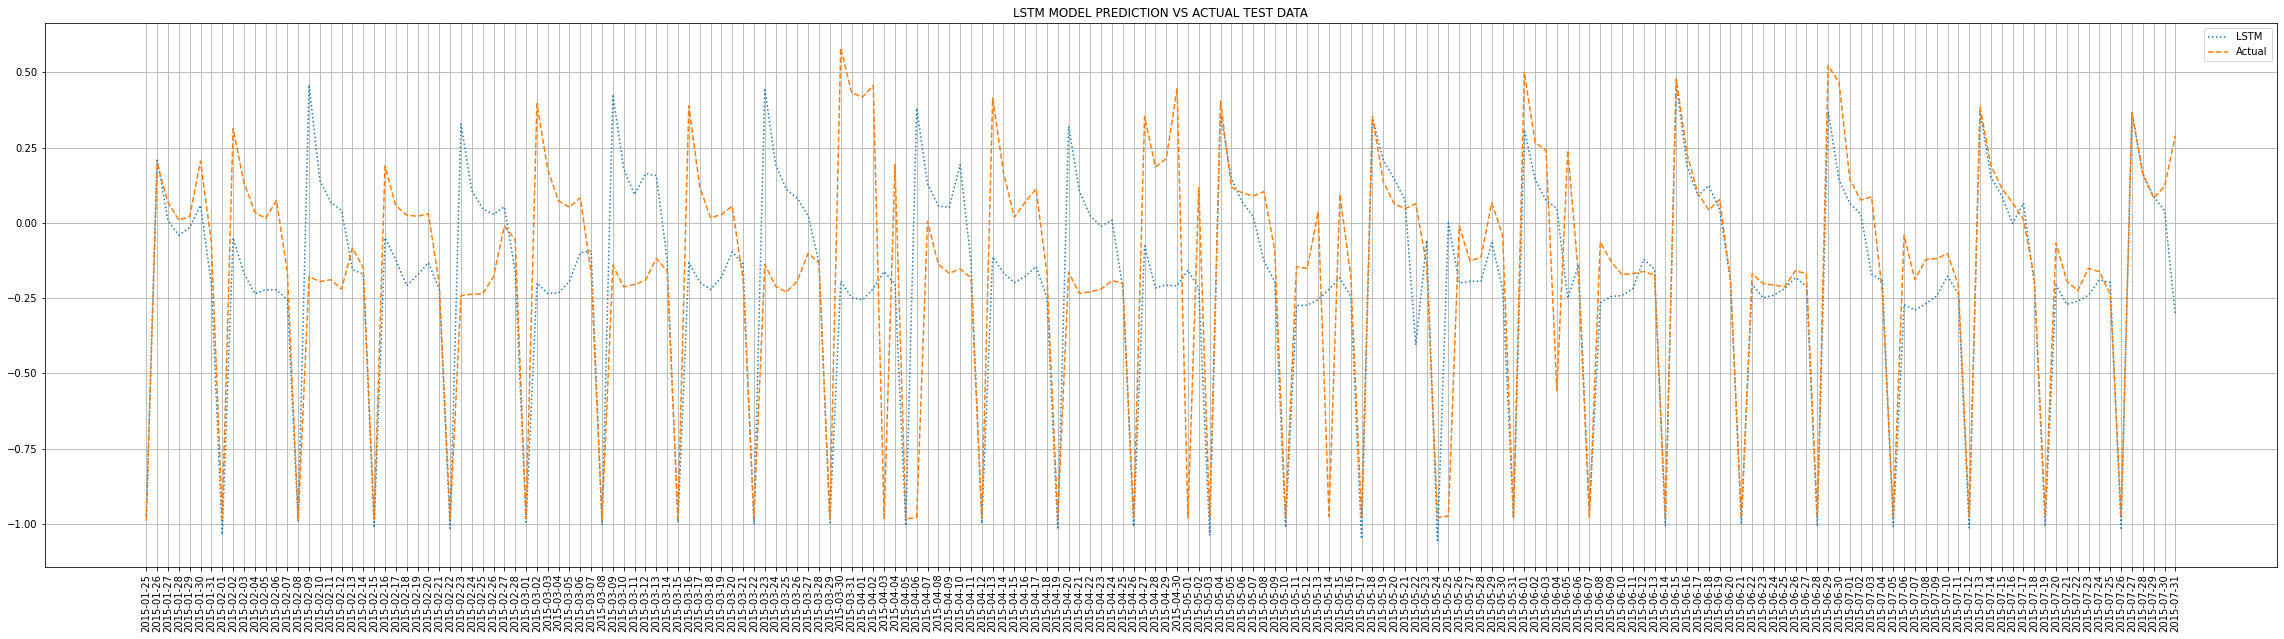

In [26]:
# Using predicted values to predict next step
X_pred = Xtest.copy()
for i in range(window, len(X_pred)):
    xin = X_pred[i-window:i].to_numpy().reshape((1, window, 1))
    X_pred[i] = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure(figsize=(40,10))
plt.title('LSTM MODEL PREDICTION VS ACTUAL TEST DATA')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred[window:], ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()

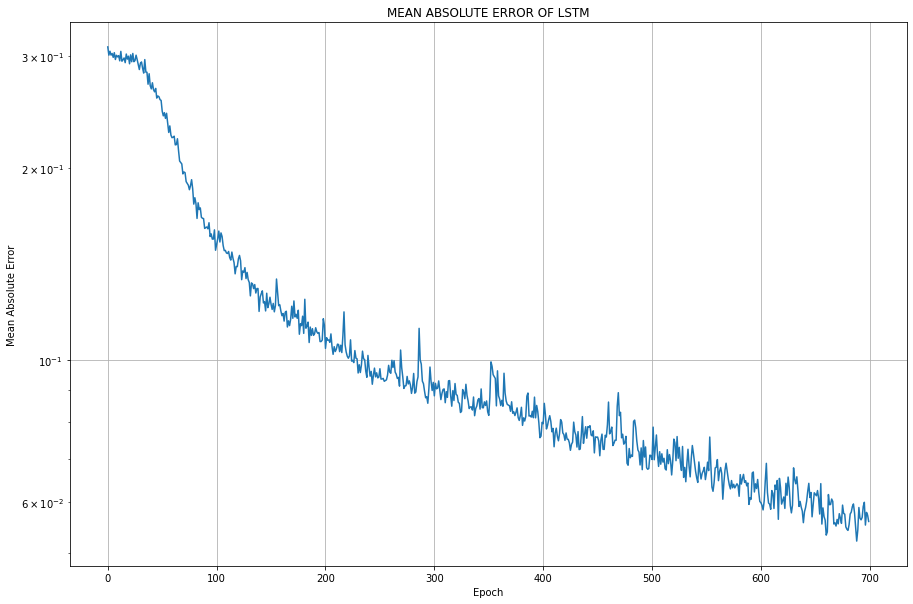

In [27]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN ABSOLUTE ERROR OF LSTM')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mae'])

In [28]:
# Last MSE Value
history.history['mse'][-1]

0.006024507340043783

In [29]:
# Last MAE Value
history.history['mae'][-1]

0.055926207453012466